In [ ]:
from keras.layers import Input, Dense, Reshape, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np

11501568/11490434 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_8 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                            

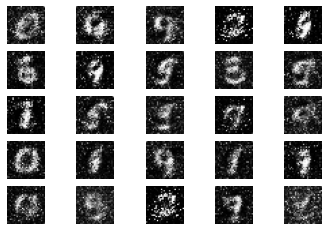

In [ ]:

class GAN():
    def __init__(self):

        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        self.batch_size = 128
        self.half_batch_size = 64
        self.latent_dim = 100
        self.iterations = 1000
        self.optimizer = Adam(0.0002, 0.5)
        self.generator_model = self.generator() 
        self.discriminator_model = self.discriminator()
        self.combined_model = self.combined()
        

    def generator(self):
        
        input_gen = Input(shape = (self.latent_dim,))
        hidden1 = BatchNormalization(momentum=0.8)(Dense(256, activation = 'relu')(input_gen))
        hidden2 = BatchNormalization(momentum=0.8)(Dense(512, activation = 'relu')(hidden1))
        hidden3 = BatchNormalization(momentum=0.8)(Dense(1024, activation = 'relu')(hidden2))
        output = Dense(784, activation='tanh')(hidden3)
        reshaped_output = Reshape((28, 28, 1))(output)
        gen_model = Model(input_gen, reshaped_output)
        gen_model.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        print(gen_model.summary())
        
        
        return gen_model
    
    def discriminator(self):
        
        input_disc = Input(shape = (784,))
        hidden1 = Dense(512, activation = 'relu')(input_disc)
        hidden2 = Dense(256, activation = 'relu')(hidden1)
        hidden3 = Dense(128, activation = 'relu')(hidden2)
        output = Dense(1, activation = 'sigmoid')(hidden3)
        disc_model = Model(input_disc, output)
        disc_model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        print(disc_model.summary())
        
        return disc_model
    
    def combined(self):
        
        inputs = Input(shape = (self.latent_dim,)) 
        gen_img = self.generator_model(inputs)
        gen_img = Reshape((784,))(gen_img)
        self.discriminator_model.trainable = False
        outs = self.discriminator_model(gen_img)
        comb_model = Model(inputs, outs)
        comb_model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        print(comb_model.summary())
        
        return comb_model
    
    def train(self):
        
        train_data = (self.x_train.astype(np.float32) - 127.5) / 127.5
        
        for i in range(self.iterations):
            
            batch_indx = np.random.randint(0, train_data.shape[0], size = (self.half_batch_size))
            batch_x = train_data[batch_indx]
            batch_x = batch_x.reshape((-1, 784))
            
            input_noise = np.random.normal(0, 1, size=(self.half_batch_size, 100))
            gen_outs = self.generator_model.predict(input_noise)
            gen_outs = gen_outs.reshape((-1, 784))
            
            fake_loss = self.discriminator_model.train_on_batch(gen_outs, np.zeros((self.half_batch_size,1)))
            real_loss = self.discriminator_model.train_on_batch(batch_x, np.ones((self.half_batch_size,1)))
            
            disc_loss = 0.5*np.add(fake_loss,real_loss)
            
            full_batch_input_noise = np.random.normal(0, 1, size=(self.batch_size, 100))
            gan_loss = self.combined_model.train_on_batch(full_batch_input_noise, np.array([1] * self.batch_size))
            
            print(i, disc_loss, gan_loss)
            
# training the network
gan = GAN()
gan.train()


# generating new images from trained network
import matplotlib.pyplot as plt

r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100))

gen_imgs = gan.generator_model.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
        
plt.show()
fig.savefig("mnist.png")
plt.close()